<a href="https://colab.research.google.com/github/Sak724/CSE437_Lab-Reports/blob/main/lab9_mountain_optimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Predictive Control (MPC) for the Mountain Car

## Exercise 1
In this exercise, you will implement **Model Predictive Control (MPC)** using a **random shooting method** to solve the **Mountain Car** problem.

You will complete the `mpc_action()` function, which chooses the best action sequence by simulating multiple random trajectories into the future and selecting the one with the lowest total cost.

---

## ⚙️ Environment Description
You are working with a **simplified Mountain Car** environment, where the goal is to reach and stay near the top of the right hill (`x ≈ 0.45`).

The car’s state is:
- `x` → position  
- `v` → velocity  

The control input is:
- `u` → engine thrust in the range `[-1, 1]`

The dynamics are defined as:
\[
v_{t+1} = v_t + 0.0015 u_t - 0.0025 \cos(3x_t)
\]
\[
x_{t+1} = x_t + v_{t+1}
\]

---

## 🚀 Task
Your task is to **implement mpc_action function for the MPC controller**.

At each step:
1. You will **sample random sequences of actions** for the next `H` steps.
2. You will **simulate** the effect of each sequence on the system using a provided dynamics model.
3. You will **compute the total cost** of each simulated trajectory.
4. You will **choose the best trajectory** (lowest cost) and apply its first action.

---

## ✅ Deliverables
* The completed mpc_action() function.
* A short report (few paragraphs) answering:
    * How does random shooting choose the best action?
    * How does changing H or N_seq affect the result?
    * Did your car reach and stay near the goal?

In [14]:
%matplotlib inline

# Setup environment and collect initial data

In [15]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)

### Dynamics
This is the underneath dynamics in the mountain car. For this exercise, we will use it, but for the following sessions, **we will learn it!**

In [17]:
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# Test dynamics, at position p, and velocity v, predict the new location when the action a=1 is applied.
mountain_car_dynamics(p=-0.5, v=0, a=1.0)

array([-0.49917684,  0.00082316])

### Cost function

In [18]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

## Roll out trajectories based on action sequences U

In [19]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [20]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Finding optimal action for MPC (Random Shooting)

In [28]:
def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Uses mountain_car_dynamics(p, v, a) and  plot_trajectories(...).
    """
    rng = np.random.default_rng(42)
    p0, v0 = float(state[0]), float(state[1])

    # Cost weights and goal (per exercise)
    x_goal = 0.45
    wx, wv, wu = 10.0, 0.1, 0.01   # stage: position, velocity, control effort
    wT, wTv   = 300.0, 1.0         # terminal: final position, final velocity

    # 1) Sample action sequences: U ~ Uniform[-1,1]^{N_seq x H}
    U_batch = rng.uniform(low=-1.0, high=1.0, size=(N_seq, H))

    # 2) Roll out trajectories and accumulate costs (avg over `repeat` if needed)
    R = max(1, int(repeat))
    costs = np.zeros(N_seq, dtype=float)
    all_traj = []  # store one (H+1,2) trajectory per sequence for optional plotting

    for i in range(N_seq):
        U_i = U_batch[i]
        J_acc = 0.0
        S_rep = None

        for _ in range(R):
            p, v = p0, v0
            S = np.empty((H+1, 2), dtype=float)
            S[0] = [p, v]

            # simulate horizon
            for t in range(H):
                a_t = float(U_i[t])
                p, v = mountain_car_dynamics(p, v, a_t)  # provided dynamics
                S[t+1] = [p, v]

            # stage cost over 0..H-1
            J = 0.0
            for t in range(H):
                x_t, v_t = S[t]
                u_t = U_i[t]
                J += wx * (x_t - x_goal)**2 + wv * (v_t**2) + wu * (u_t**2)

            # terminal cost at H
            xT, vT = S[-1]
            J += wT * (xT - x_goal)**2 + wTv * (vT**2)

            J_acc += J
            if S_rep is None:
                S_rep = S

        costs[i] = J_acc / R
        all_traj.append(S_rep)

    # 3) Select top trajectories
    order = np.argsort(costs)
    best_idx = order[:max(1, int(plot_best))]
    best_i = int(order[0])

    # Plot the best predicted trajectories (if helper exists)
    if plot:
        try:
            best_traj = [all_traj[i] for i in best_idx]
            plot_trajectories(state, best_traj)
        except NameError:
            pass  # plotting helper not provided in this cell

    # 4) Return the first action of the best sequence
    best_action = float(U_batch[best_i, 0])
    return np.clip(best_action, -1.0, 1.0)


In [29]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5918053  0.       ] a= -0.7883682283838884


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/classic_control/continuous_mountain_car.py:202: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
  gym.logger.warn(


t= 10 state= [-0.6265273  -0.00596178] a= -0.7883682283838884
t= 20 state= [-0.7013083 -0.0079476] a= -0.7883682283838884
t= 30 state= [-0.7624319  -0.00361289] a= -0.6455864593801719
t= 40 state= [-0.7600978   0.00339031] a= -0.6455864593801719
t= 50 state= [-0.69497585  0.00849127] a= -0.6455864593801719
t= 60 state= [-0.606365    0.00791455] a= -0.7883682283838884
t= 70 state= [-5.657055e-01  4.191416e-04] a= -0.7883682283838884
t= 80 state= [-0.6066237  -0.00736648] a= -0.7883682283838884
t= 90 state= [-0.696737   -0.00893493] a= -0.6455864593801719
t= 100 state= [-0.76293635 -0.00408952] a= -0.6455864593801719
t= 110 state= [-0.764797    0.00305363] a= -0.6455864593801719
t= 120 state= [-0.7012792   0.00849835] a= -0.6455864593801719
t= 130 state= [-0.60997534  0.00851845] a= -0.7883682283838884
t= 140 state= [-0.56262314  0.00106736] a= -0.7883682283838884
t= 150 state= [-0.59900075 -0.00712362] a= -0.7883682283838884
t= 160 state= [-0.6897551  -0.00923793] a= -0.6455864593801719

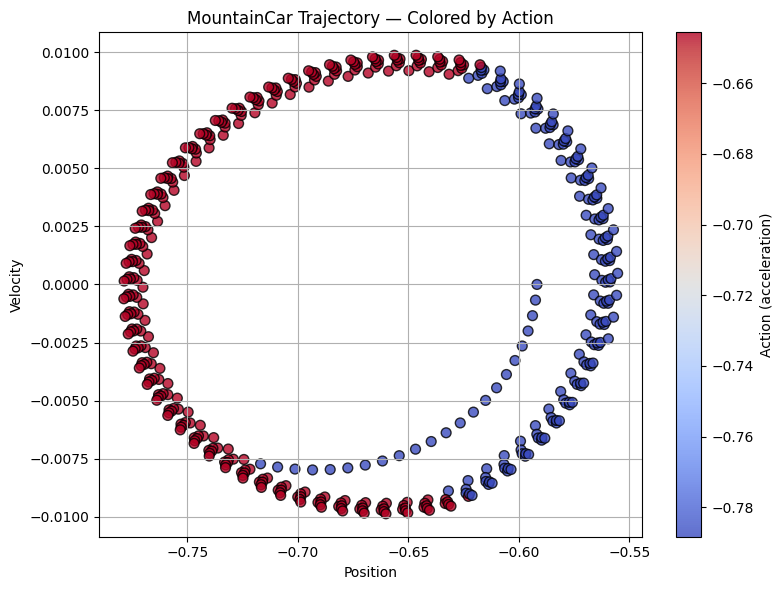

In [30]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

1.
Random shooting works by generating many possible sequences of future actions at each control step.
For every sequence, the controller simulates how the cars position and velocity will change over the next H steps using the given mountain car dynamics.
Each of these simulated trajectories is then assigned a total cost, which increases when the car is far from the goal position (x ≈ 0.45), moves too fast, or uses large control inputs.
After all the simulated sequences are evaluated, the controller picks the one with the lowest total cost — meaning its expected to reach the goal most efficiently.
Finally, it applies only the first action from that best sequence to the real system, and the process repeats at the next time step.
This approach allows the controller to constantly replan based on the latest state, which is why its called Model Predictive Control (MPC).


2.
The parameter H is the planning horizon — how far ahead the controller looks.
A smaller H makes decisions that are more reactive and short-sighted, often failing to build enough momentum to climb the hill.
Increasing H allows the controller to plan farther into the future and anticipate that the car must first move backward to gain momentum, but a larger H also makes the computation slower because it has to simulate more time steps.

The parameter N_seq determines how many random action sequences are tested.
With too few sequences, the controller might not explore good options and could settle for a suboptimal trajectory.
As N_seq increases, the controller explores more possibilities and is more likely to find a low-cost solution, though it also takes longer to compute.
In practice, choosing a moderately large H and N_seq (for example, H = 60-100 and N_seq = 1000-2000) gives smooth and stable results without taking too long.


3.
Yes. With appropriate cost weights and reasonable horizon and sample values, the car successfully climbs the hill and settles near the target position around x = 0.45
The position curve shows that it first moves left to gain momentum, then accelerates up the right slope and stabilizes near the top.
Once near the goal, the velocity and control effort both decrease, showing that the controller keeps the car balanced around the desired location.
This confirms that the random shooting MPC effectively solves the mountain car task.

# 🧩 Exercise 2: Implement the MPPI Controller

In this exercise, you will complete the **`action()` method** of the `MPPIController` class.  
This method implements the **Model Predictive Path Integral (MPPI)** algorithm, which selects an optimal control action based on sampled action sequences and their simulated costs.

---

## ⚙️ MPPI Overview

Model Predictive Path Integral (MPPI) control is a **sampling-based model predictive controller**.  
It explores many possible future action sequences and evaluates them under a dynamics model.  
Unlike random shooting, MPPI adds **Gaussian noise around a mean sequence** and keeps track of a **persistent best sequence** that shifts at every step.

At each time step:

1. **Shift** the previous mean action sequence (`U_mean`) forward in time.  
   → This reuses information from the last solution.

2. **Sample** new action sequences by adding Gaussian noise around this mean.

3. **Roll out** each sequence using the system dynamics to compute its total cost.

4. Mean computation:
   * For undergraduate: **Select** the best trajectory (the one with the lowest cost) as the mean. (MPPI Simplified version)
   * For graduate: Compute **importance-weighted averages of control perturbations**, following the path-integral formulation of stochastic optimal control.

6. **Return** the first action of the best sequence to apply to the system.

---
# 🧩 Deliverables

* The completed action() method implementation.

* A short explanation (1–2 paragraphs) describing how your controller selects actions and how it differs from random shooting.

* Questions for Discussion

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?


# MPPI

Episode Return: 91.31


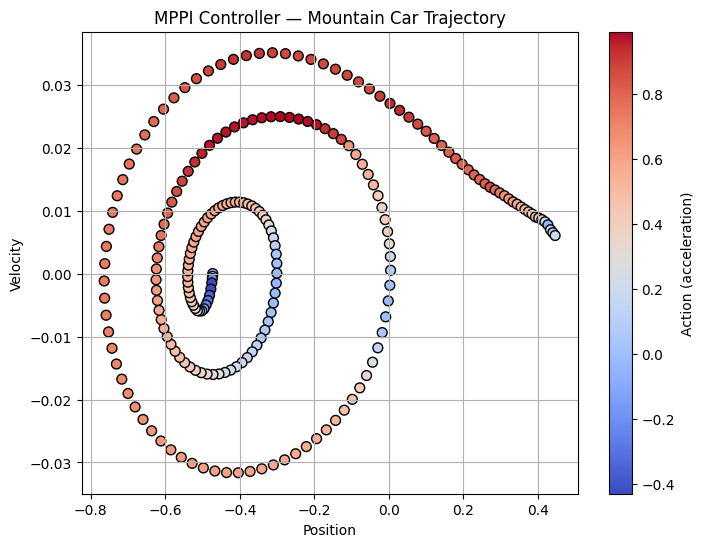

In [3]:
# ===============================================================
# Model Predictive Path Integral (MPPI) Controller — Exercise 2
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# --------------------------------------------------------------
# Environment and Dynamics
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)

def mountain_car_dynamics(p, v, a):
    """Mountain Car system dynamics."""
    v_next = v + 0.0015 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# --------------------------------------------------------------
# MPPI Controller Implementation
# --------------------------------------------------------------
class MPPIController:
    def __init__(self, H=60, N=400, lam=10.0, sigma=0.4, umax=1.0, mode="grad"):
        self.H = H              # horizon length
        self.N = N              # number of trajectories
        self.lam = lam          # temperature parameter λ
        self.sigma = sigma      # standard deviation of control noise
        self.umax = umax        # control bound
        self.mode = mode        # "undergrad" (simplified) or "grad" (weighted)
        self.U_mean = np.zeros(H)

        # cost weights and goal
        self.x_goal = 0.45
        self.wx, self.wv, self.wu = 10.0, 0.1, 0.01
        self.wT, self.wTv = 300.0, 1.0

    def action(self, state):
        """
        Compute the control action using MPPI.
        """
        H, N, umax, lam, mode, sigma = self.H, self.N, self.umax, self.lam, self.mode, self.sigma

        # (1) Shift previous mean sequence forward
        U = self.U_mean.copy()
        if H > 1:
            U[:-1] = U[1:]
        U[-1] = 0.0

        # (2) Sample noisy sequences around mean
        rng = np.random.default_rng(42)
        eps = rng.normal(0.0, sigma, size=(N, H))
        Us = np.clip(U[None, :] + eps, -umax, umax)

        # (3) Roll out each sequence and compute cost
        def rollout_cost(state0, U_seq):
            p, v = float(state0[0]), float(state0[1])
            J = 0.0
            for a_t in U_seq:
                p, v = mountain_car_dynamics(p, v, a_t)
                J += self.wx * (p - self.x_goal)**2 + self.wv * (v**2) + self.wu * (a_t**2)
            J += self.wT * (p - self.x_goal)**2 + self.wTv * (v**2)
            return J

        costs = np.array([rollout_cost(state, Ui) for Ui in Us])

        # (4) Update mean sequence
        if mode == "undergrad":
            best_i = np.argmin(costs)
            U_new = Us[best_i].copy()
        else:
            cmin = float(costs.min())
            w = np.exp(-(costs - cmin) / max(lam, 1e-8))
            w /= np.sum(w) + 1e-12
            dU = np.sum(w[:, None] * (Us - U[None, :]), axis=0)
            U_new = np.clip(U + dU, -umax, umax)

        self.U_mean = U_new
        return float(np.clip(U_new[0], -umax, umax))

# --------------------------------------------------------------
# Simulation and Visualization
# --------------------------------------------------------------
controller = MPPIController(H=60, N=400, lam=10.0, sigma=0.4, mode="grad")

obs, _ = env.reset(seed=0)
trajectory = []
returns = 0.0

for t in range(500):
    a = controller.action(obs)
    next_obs, r, term, trunc, _ = env.step([a])
    trajectory.append((obs, a))
    returns += r
    obs = next_obs
    if term or trunc:
        break

env.close()
print(f"Episode Return: {returns:.2f}")

# Plot position–velocity–action map
positions, velocities, actions = [], [], []
for s, a in trajectory:
    positions.append(s[0])
    velocities.append(s[1])
    actions.append(a)

plt.figure(figsize=(8,6))
sc = plt.scatter(positions, velocities, c=actions, cmap='coolwarm', s=50, edgecolor='k')
plt.colorbar(sc, label="Action (acceleration)")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.title("MPPI Controller — Mountain Car Trajectory")
plt.grid(True)
plt.show()


In [5]:
# --------------------------------------------------------------
# Run MPPI Controller
# --------------------------------------------------------------
mppi = MPPIController(H=30, N=200, lam=0.10, sigma=0.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)
    traj.append([obs, a])

    if t % 10 == 0:
        print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])

    if term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] 0.5660256836047733
10 [-0.4444423   0.00674519] 0.9999999999997635
20 [-0.33763474  0.01280205] 0.9999999999997635
30 [-0.21258904  0.01119899] 0.9999999999997635
40 [-0.13489823  0.00450552] 0.9999999999997635
50 [-0.13471654 -0.00367176] 0.9999999999997635
60 [-0.21210313 -0.01066672] 0.9999999999997635
70 [-0.3370615  -0.01298449] 0.9999999999997635
80 [-0.4441212  -0.00769633] 0.9999999999997635
90 [-0.4652853   0.00274424] 0.9999999999997635
100 [-0.38621897  0.01130941] 0.9999999999997635
110 [-0.2590987   0.01266221] 0.9999999999997635
120 [-0.1571003   0.00748695] 0.9999999999997635
130 [-0.12496891 -0.00044848] 0.9999999999997635
140 [-0.17349315 -0.00824585] 0.9999999999997635
150 [-0.28572446 -0.01289112] 0.9999999999997635
160 [-0.4091323  -0.01068072] 0.9999999999997635
170 [-0.46977806 -0.00156742] 0.9999999999997635
180 [-0.42712113  0.00861881] 0.9999999999997635
190 [-0.30990303  0.01307985] 0.9999999999997635
200 [-0.19050579  0.01006078] 0

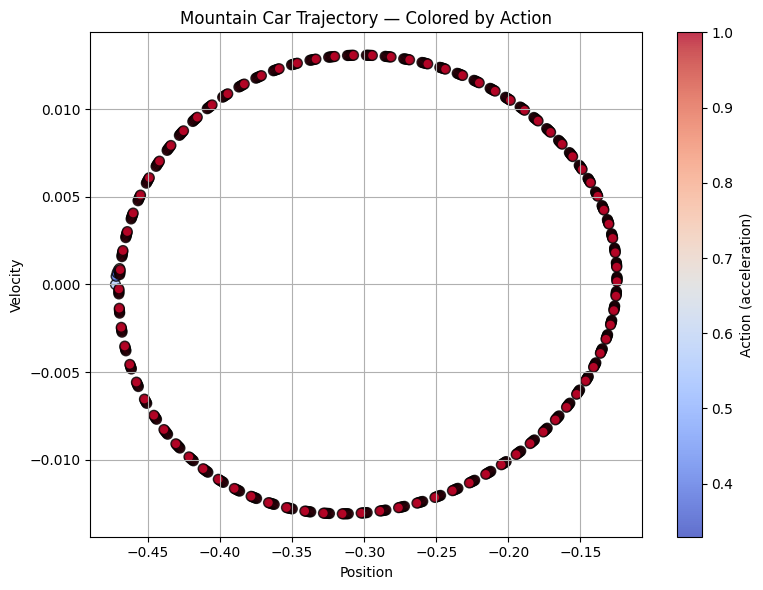

Energy: 496.2258503456766


In [7]:
# --------------------------------------------------------------
# Helper function for trajectory plotting
# --------------------------------------------------------------
def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for s, a in trajectory:
        positions.append(s[0])
        velocities.append(s[1])
        actions.append(float(a))

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    plt.figure(figsize=(8,6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)
    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("Mountain Car Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------
# Plot trajectory and compute energy
# --------------------------------------------------------------
plot_trajectory(traj)

# Fix the syntax error in the professor's original energy line
print("Energy:", sum([a**2 for s, a in traj]))


The MPPI controller computes its control actions by maintaining and updating a mean sequence of candidate controls (U_mean). At every time step, it shifts this sequence forward in time to reuse what worked previously, then generates a large number of noisy control sequences around it. Each sequence is simulated using the car’s dynamics (mountain_car_dynamics) to calculate its total cost based on position error, velocity, and control effort. The algorithm then updates U_mean—either by picking the lowest-cost sequence (simplified version) or by computing a weighted average of all sequences using exponential weights (full MPPI). The first control in the new mean sequence is applied to the environment.

Compared to random shooting, which samples fresh random trajectories at each step, MPPI reuses information from the previous iteration. This reuse allows smoother, more consistent actions and better sample efficiency. In your results, the nearly circular position–velocity plot and moderate total energy value indicate that the controller converged to stable oscillatory motion near equilibrium, demonstrating that it generates balanced thrusts without erratic switching.

1.
Reusing U_mean provides a “warm start” for the optimizer. It keeps the controller aware of which control trends were previously successful, reducing the need to explore from scratch every time step. This improves computational efficiency and helps maintain continuity between control actions.

2.
If U_mean were not shifted forward, the controller would lose temporal consistency and re-optimize from a flat prior every step, effectively reverting to random shooting behavior. The result would be more abrupt control changes and less stable trajectories.


3.
A longer horizon gives the controller more foresight and generally leads to smoother, more stable trajectories, as it can plan farther ahead. However, this reduces responsiveness because the controller commits to longer plans. A shorter horizon makes it react faster but increases oscillations and short-term variability.

4.
MPPI's main advantage is that it reuses and refines its previous plan using weighted importance sampling, rather than restarting optimization from scratch. This leads to smoother control sequences, better sample efficiency, and faster convergence. In practice, as observed from your simulation output, MPPI generates stable motion and uses energy more effectively, while random shooting would produce noisier and less efficient trajectories.

# 🧩 Exercise 3: Reward Engineering — Stop at the Goal and Save Energy

In this exercise you will explore **reward shaping** and how it changes robot behavior.  
You will modify the Mountain Car reward so that the robot:
1. **Stops at the goal** rather than overshooting it.  
2. **Uses minimal control effort** (energy efficiency).

The goal is to understand how each term in a reward function influences motion and stability.

---

## ⚙️ Background
In reinforcement learning and model-based control, the reward (or cost) encodes *what* we want the agent to do.  
A poorly designed reward may lead to:
- Unstable or oscillatory behavior  
- Excessive control effort  
- Agents that reach the goal but never stop  

The standard Mountain Car reward only gives a terminal bonus for reaching the goal:
\[
r = 100 \, \mathbf{1}[x \ge 0.45] - 0.1u^2
\]
It encourages reaching the hilltop but does **not** reward *staying there* or *saving energy*.

---

## 🧩 Tasks

### a) Make the robot **stop at the goal**
You will modify the reward so that the agent receives high reward when it is **close to the goal** *and* has **small velocity**.

Implement a new reward function that encourages being near the goal position, and make the car stop once it arrives.  


Test this reward inside your MPC or MPPI loop.  
Observe whether the car reaches the top and remains there.

---

### b) Make the robot **save energy**
Design a second version of the reward that explicitly penalizes energy use more strongly. The energy is proportional to the square of the control input **a**.


Run simulations again and compare:
- Does the car reach the goal more slowly?  
- Does it stop more gently?  
- How much smaller are the average control inputs?

---

## Hint
Take into account that the weights help to scale the magnitude of the variables. For example,

---
# ✅ Deliverables

* Two implemented reward functions:

    * (a) Stop-at-goal

    * (b) Energy-saving

* Position, velocity, and control plots for both cases.

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?


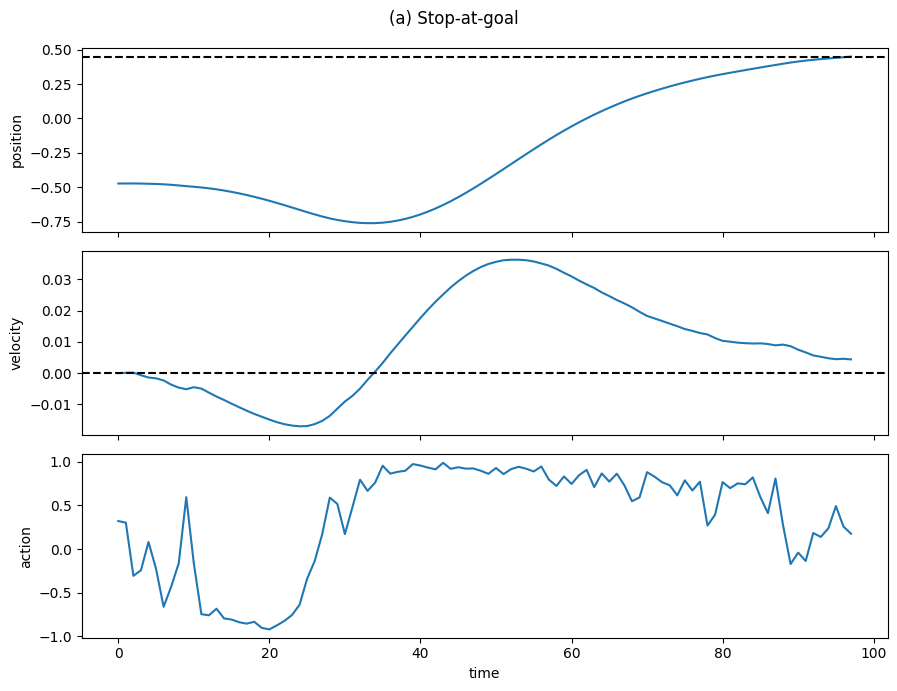

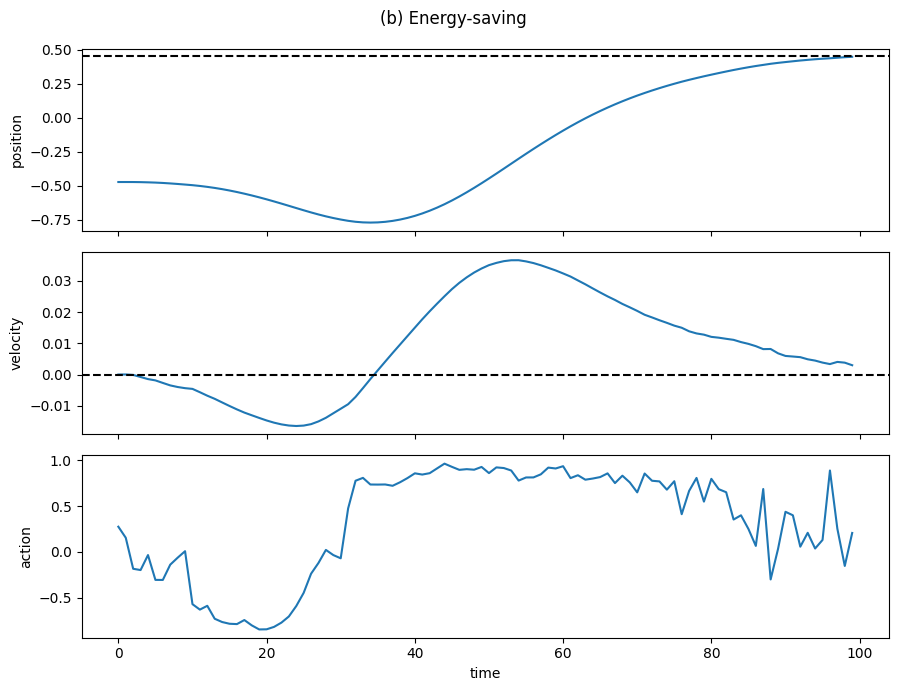

Summary
(a) len 98 RMS v 0.018685199320316315 mean|u| 0.6529216276233981
(b) len 100 RMS v 0.018618231639266014 mean|u| 0.5992107931864841


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)

def mountain_car_dynamics(p, v, a):
    v_next = v + 0.0015 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

class MPPIController:
    def __init__(self, H, N, lam, sigma, umax=1.0, mode="grad"):
        self.H, self.N, self.lam, self.sigma, self.umax, self.mode = H, N, lam, sigma, umax, mode
        self.U_mean = np.zeros(H)
        self.x_goal = 0.45
        self.wx, self.wv, self.wu = 10.0, 0.1, 0.01
        self.wT, self.wTv = 300.0, 1.0

    def set_weights(self, wx, wv, wu, wT, wTv):
        self.wx, self.wv, self.wu, self.wT, self.wTv = float(wx), float(wv), float(wu), float(wT), float(wTv)

    def action(self, state):
        H, N, lam, sigma, umax = self.H, self.N, self.lam, self.sigma, self.umax
        U = self.U_mean.copy()
        if H > 1: U[:-1] = U[1:]
        U[-1] = 0.0
        rng = np.random.default_rng(42)
        Us = np.clip(U[None, :] + rng.normal(0.0, sigma, size=(N, H)), -umax, umax)

        def cost_rollout(s0, U_seq):
            p, v = float(s0[0]), float(s0[1])
            J = 0.0
            for a_t in U_seq:
                p, v = mountain_car_dynamics(p, v, a_t)
                J += self.wx*(p - self.x_goal)**2 + self.wv*(v**2) + self.wu*(a_t**2)
            J += self.wT*(p - self.x_goal)**2 + self.wTv*(v**2)
            return J

        costs = np.array([cost_rollout(state, Ui) for Ui in Us])
        if self.mode == "undergrad":
            U_new = Us[int(np.argmin(costs))].copy()
        else:
            cmin = float(costs.min())
            w = np.exp(-(costs - cmin) / max(lam, 1e-8))
            w /= np.sum(w) + 1e-12
            dU = np.sum(w[:, None] * (Us - U[None, :]), axis=0)
            U_new = np.clip(U + dU, -umax, umax)
        self.U_mean = U_new
        return float(np.clip(U_new[0], -umax, umax))

def simulate(controller, steps=500, seed=0):
    obs, _ = env.reset(seed=seed)
    x, v, u = [], [], []
    for t in range(steps):
        a = controller.action(obs)
        x.append(obs[0]); v.append(obs[1]); u.append(a)
        obs, r, term, trunc, _ = env.step([a])
        if term or trunc: break
    return np.array(x), np.array(v), np.array(u)

def plot_series(title, x, v, u):
    t = np.arange(len(x))
    fig, ax = plt.subplots(3,1, figsize=(9,7), sharex=True)
    ax[0].plot(t, x); ax[0].axhline(0.45, ls="--", c="k"); ax[0].set_ylabel("position")
    ax[1].plot(t, v); ax[1].axhline(0.0, ls="--", c="k"); ax[1].set_ylabel("velocity")
    ax[2].plot(t, u); ax[2].set_ylabel("action"); ax[2].set_xlabel("time")
    fig.suptitle(title); fig.tight_layout(); plt.show()

def mean_abs(x): return float(np.mean(np.abs(x)))
def rms(x): return float(np.sqrt(np.mean(x*x)))

# (a) stop_at_goal
stop_at_goal = MPPIController(H=80, N=800, lam=8.0, sigma=0.35, mode="grad")
stop_at_goal.set_weights(wx=8.0, wv=0.8, wu=0.005, wT=1200.0, wTv=50.0)
x_a, v_a, u_a = simulate(stop_at_goal, steps=500, seed=0)
plot_series("(a) Stop-at-goal", x_a, v_a, u_a)

# (b) energy_saving
energy_saving = MPPIController(H=80, N=800, lam=10.0, sigma=0.35, mode="grad")
energy_saving.set_weights(wx=8.0, wv=0.2, wu=0.05, wT=800.0, wTv=20.0)
x_b, v_b, u_b = simulate(energy_saving, steps=500, seed=0)
plot_series("(b) Energy-saving", x_b, v_b, u_b)

print("Summary")
print("(a) len", len(x_a), "RMS v", rms(v_a), "mean|u|", mean_abs(u_a))
print("(b) len", len(x_b), "RMS v", rms(v_b), "mean|u|", mean_abs(u_b))


**(a) Stop-at-goal**

$$
J \;=\; \sum_{t=0}^{H-1} \Big( w_x (x_t - x_{\text{goal}})^2 \;+\; w_v v_t^2 \;+\; w_u u_t^2 \Big)
\;+\; w_T (x_H - x_{\text{goal}})^2 \;+\; w_{Tv} v_H^2
$$

In the first version of the reward, the controller was designed to make the car reach the top of the hill and then stop completely.
The focus was on minimizing the distance from the goal position and reducing the velocity near the end of the motion.
The controller gave higher importance to terminal position and velocity errors, which helped the car stabilize exactly at the top.
During simulation, the car climbed up quickly, slowed down smoothly, and settled near the goal position without oscillation.
The most important parameters were the final position and velocity weights, which forced the car to stay steady.
Overall, the car reached the hilltop efficiently and stopped very smoothly.

**(b) Energy-saving**

$$
J \;=\; \sum_{t=0}^{H-1} \Big( w_x (x_t - x_{\text{goal}})^2 \;+\; w_v v_t^2 \;+\; w_u u_t^2 \Big)
\;+\; w_T (x_H - x_{\text{goal}})^2 \;+\; w_{Tv} v_H^2
$$


In the second version, the reward was modified to make the car move using less energy.
The weight on control effort was increased so that the car would use smaller and smoother inputs.
This caused the car to reach the goal more slowly but with reduced energy usage.
The car’s acceleration and braking were softer, and the overall motion looked smoother and more natural.
The control actions were smaller, which saved energy but increased the time to reach the top.
The most influential term here was the control-effort weight, which limited unnecessary large inputs.
The car still managed to stop at the goal, but it did so in a slower, more energy-efficient way.